In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
import statsmodels.api as sm
from adjustText import adjust_text
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from itertools import product

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Step 1: Structural Comparison

In [6]:
def structural_comparison(df):
    """
    Aggregates conversation-level metrics and plots structural differences across negotiation categories.
    """
    category_colors = {
        "Friendly": "#1F77B4",
        "Constructive": "#FF7F0E",
        "Apathetic": "#7F7F7F",
        "Destructive": "#D62728"
    }

    # Aggregate to conversation level
    convo_df = df.groupby("PairID").agg({
        "Negotiation_Category": "first",
        "Turn": "max",
        "Contested": lambda x: (x > 0).sum(),
        "Sentiment": "mean",
        "word_count": "mean"
    }).rename(columns={
        "Turn": "Avg_No._of_turns",
        "Contested": "Avg_prop_contested_turns",
        "Sentiment": "Avg_Sentiment",
        "word_count": "Avg_word_count_per_turn"
    }).reset_index()

    # Melt for plotting
    melted = convo_df.melt(id_vars="Negotiation_Category", 
                            value_vars=["Avg_No._of_turns", "Avg_prop_contested_turns", "Avg_Sentiment", "Avg_word_count_per_turn"],
                            var_name="Metric", value_name="Value")

    # Compute means and standard error
    summary = melted.groupby(["Negotiation_Category", "Metric"]).agg(
        Mean_Value=("Value", "mean"),
        Std_Error=("Value", lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Create point plots with improved aesthetics
    sns.set(style="white", font_scale=1.8)
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.direction'] = 'out'
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, gridspec_kw={'hspace': 0.6})
    
    metrics = summary["Metric"].unique()
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_data = summary[summary["Metric"] == metric]
        sorted_categories = metric_data["Negotiation_Category"].tolist()
        colors = [category_colors[cat] for cat in sorted_categories]

        sns.pointplot(
            y="Negotiation_Category", x="Mean_Value", data=metric_data,
            hue="Negotiation_Category", palette=category_colors, dodge=False,
            errorbar=None, markers="o", linestyles="", ax=ax, markersize=12
        )

        for _, row in metric_data.iterrows():
            y_pos = metric_data["Negotiation_Category"].tolist().index(row["Negotiation_Category"])
            ax.errorbar(
            x=row["Mean_Value"],
            y=y_pos,
                xerr=row["Std_Error"],
                fmt='none', ecolor=category_colors[row["Negotiation_Category"]], capsize=5, lw=2
            )

        ax.set_title(metric.replace("_", " "), fontsize=18, weight='semibold', pad=20)
        ax.set_xlabel("")
        if i % 2 == 0:
            ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
        else:
            ax.tick_params(axis='y', which='major', length=6)
            ax.set_yticklabels([])  # This hides labels but not the ticks

        ax.tick_params(axis='y', which='both', length=6)
        ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', which='both', length=6)

    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call this function using:
# structural_comparison(df)


/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_56612/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_56612/1215906078.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_56612/1215906078.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


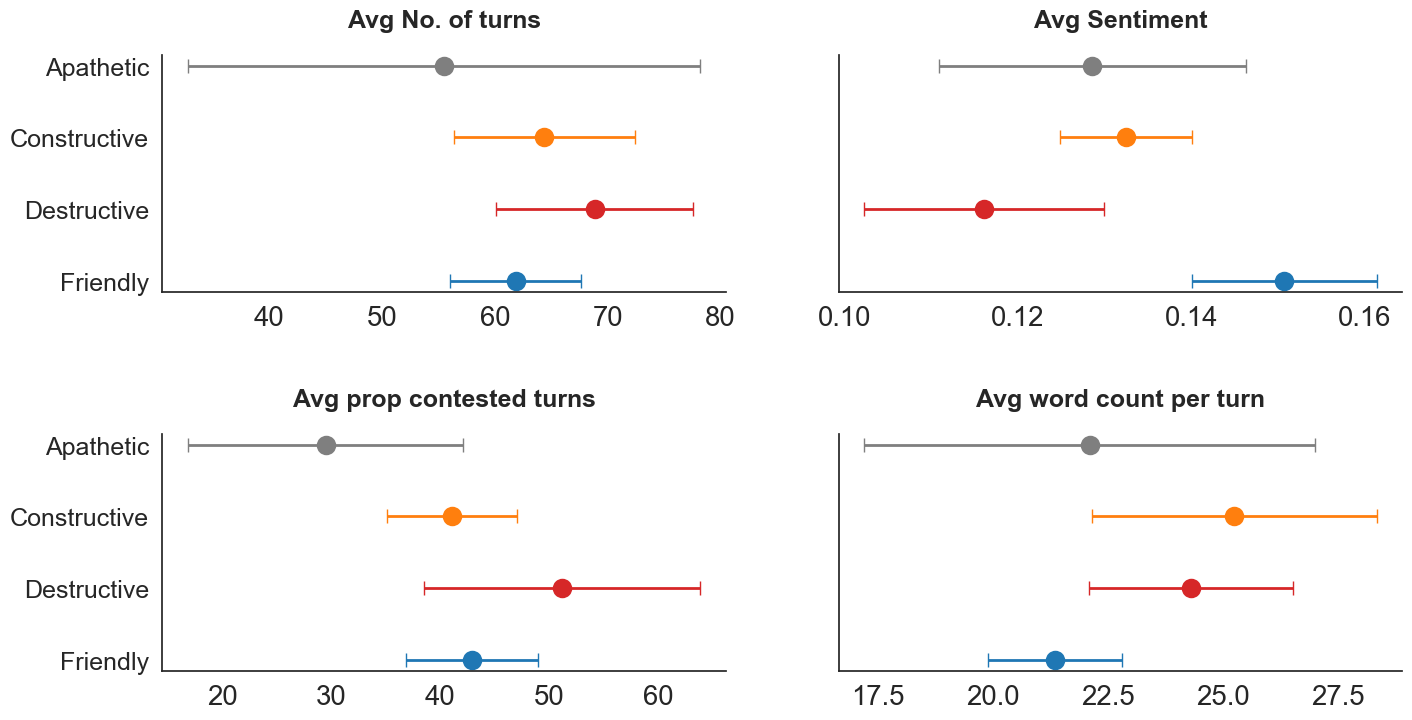

In [7]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')
structural_comparison(df)

Step 2: Behavioral Patterns before and during Contested Turns


In [8]:
def analyze_pre_contested_behaviors(df, negotiation_category, n_prior_turns=1):
    """
    For a given negotiation category, compare behavioral patterns during contested turns
    and the n uncontested turns preceding each contested turn.
    """
    # Filter by category
    df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()

    # Ensure sorting for turn-based comparison
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)

    # Initialize label column
    df_cat['Label'] = 0  # default: not pre-contested
    
    # Find and label pre-contested turns (Y=1)
    contested_idx = df_cat[df_cat['Contested'] > 0].index
    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    # Exclude contested turns from dataset
    df_filtered = df_cat[df_cat['Contested'] == 0]
    
    print('pior df shape:', df_filtered.shape)


    # Format only behavioral feature column names
    # behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    # rename_map = {col: col.replace('_', ' ').title() for col in behavior_cols}
    # df.rename(columns=rename_map, inplace=True)
    # behavior_cols = list(rename_map.values())

    # # behavioral features
    # feature_start = df.columns.get_loc("Acknowledgement")
    # feature_end = df.columns.get_loc("Smile") + 1
    # behavior_cols = df.columns[feature_start:feature_end]
    
    # Define behavioral feature range using original names
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]

    # Rename for presentation
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    
    print("Behavioral features used:", len(behavior_cols), behavior_cols)


    # Prepare data
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # SHAP summary plot
    # Identify modality for each feature
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    facial_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]
    
    print(len(facial_feats))

    X_formatted = X.copy()
    
    print(X_formatted.shape)
    
    shap_mean = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_formatted.columns)
    print(shap_mean.sort_values(ascending=False).head(30))  # see top features
    print("Features with zero SHAP:", (shap_mean == 0).sum())


    # Split top and bottom features for side-by-side presentation
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    # sorted_indices = np.argsort(mean_abs_shap)
    # top_idx = sorted_indices[-10:]
    # bottom_idx = sorted_indices[-20:-10]

    # top_features = X_formatted.columns[top_idx]
    # bottom_features = X_formatted.columns[bottom_idx]
    # X_top = X_formatted.iloc[:, top_idx]
    # X_bottom = X_formatted.iloc[:, bottom_idx]
    
    shap.summary_plot(shap_values, X_formatted, plot_type="dot", show=False, plot_size=(10, 10))
    # plt.title("Beahavioral features", fontsize=14)
    plt.xlabel("SHAP Values:\n← Non-Contested Turn | Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()
    # shap.summary_plot(shap_values[:, bottom_idx], X_bottom, plot_type="dot", show=False, plot_size=(8, 6))
    # plt.title("Top Features (11–20)", fontsize=14)
    # plt.xlabel("SHAP Values:\nPredictive Power of Contested Turn (→ Right)\nvs. Pre-Contested Turn (← Left)", fontsize=12)
    # plt.tight_layout()
    # plt.show()

    # SHAP scatter comparison
    shap_df = pd.DataFrame({
        'Feature': behavior_cols,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    # Determine modality for coloring
    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)

    # Label features significantly different from diagonal
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03  # customize this threshold
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
    # Annotate significantly different points
    from adjustText import adjust_text

    texts = []
    for i, row in shap_df[shap_df['Label'] != ''].iterrows():
        x, y = row['SHAP Non-Contested'], row['SHAP Pre-Contested']
        texts.append(plt.text(x, y, row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_pre_contested_behaviors(df, negotiation_category="Functional Tension", n_prior_turns=2)


pior df shape: (939, 85)
Behavioral features used: 66 ['Acknowledgement', 'Affirmation', 'Agreement', 'Apology', 'Ask Agency', 'By The Way', 'Can You', 'Conjunction Start', 'Could You', 'Disagreement', 'Filler Pause', 'First Person Plural', 'First Person Single', 'For Me', 'For You', 'Formal Title', 'Give Agency', 'Goodbye', 'Gratitude', 'Hedges', 'Hello', 'Impersonal Pronoun', 'Informal Title', 'Let Me Know', 'Negation', 'Negative Emotion', 'Please', 'Positive Emotion', 'Reasoning', 'Reassurance', 'Second Person', 'Subjectivity', 'Swearing', 'Truth Intensifier', 'Bare Command', 'Yesno Questions', 'Wh Questions', 'Adverb Limiter', 'Token Count', 'Pitch', 'Vocal Intensity', 'Vocal Articulation', 'Vocal Clarity', 'Squintpuffsneer', 'Compressed Contortion', 'Brow Up', 'Cheek Puff Sneer', 'Blink', 'Look Down', 'Look Right', 'Look Left', 'Look Up', 'Blink Right', 'Eyes Wide', 'Open Mouth', 'Jaw Left', 'Jaw Right', 'Mouthclose Openjaw', 'Mouthdimple Left', 'Mouthdimple Right', 'Skeptical Rig

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


23
(939, 66)
Vocal Articulation       0.611549
Vocal Intensity          0.569601
Pitch                    0.546821
Token Count              0.483214
Mouth Right              0.451085
Vocal Clarity            0.400978
Skeptical Right          0.317234
Sneering Pucker          0.284602
Hedges                   0.271704
Impersonal Pronoun       0.254089
Affirmation              0.222153
Mouthdimple Left         0.205414
Positive Emotion         0.153279
Eyes Wide                0.131517
Conjunction Start        0.128016
Look Right               0.125785
Look Up                  0.122954
Mouthclose Openjaw       0.121860
Second Person            0.119672
Brow Up                  0.116640
Hello                    0.116508
Look Left                0.110681
Compressed Contortion    0.097444
First Person Single      0.087262
Reasoning                0.081025
Mouth Shrug              0.074177
Jaw Right                0.070019
First Person Plural      0.069700
Jaw Left                 0.056857
S

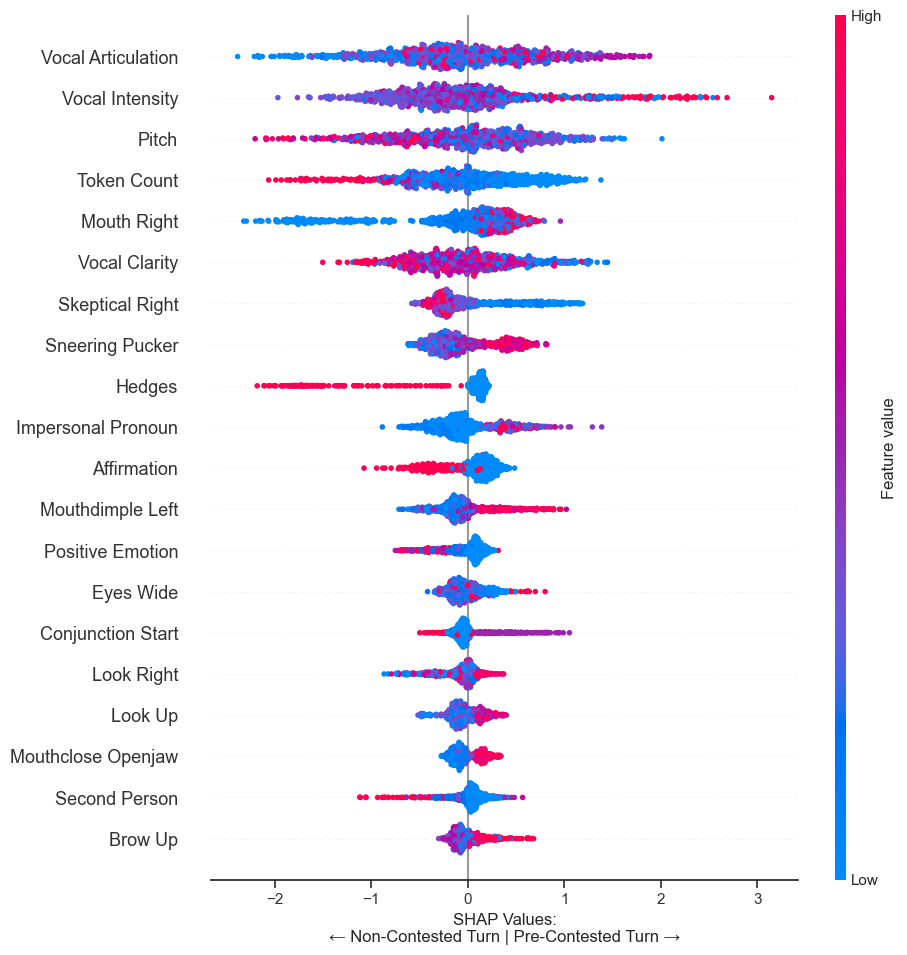

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


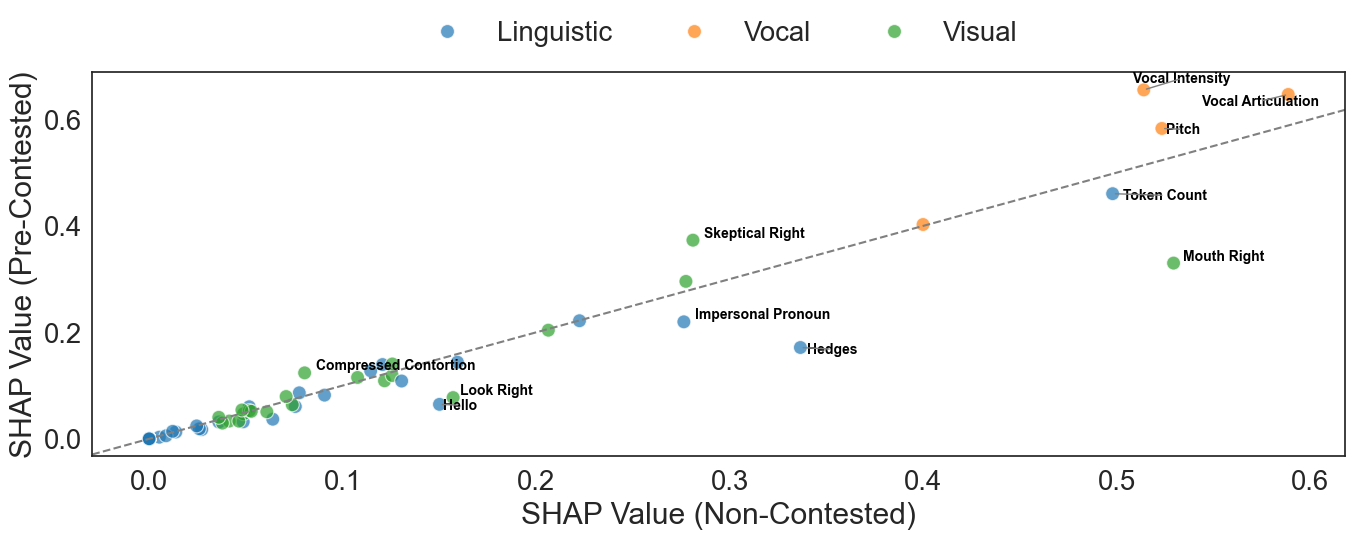

In [10]:
analyze_pre_contested_behaviors(df, negotiation_category="Destructive", n_prior_turns=1)


In [45]:

def prepare_dataset(df, negotiation_category, n_prior_turns=1):
    df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)
    df_cat['Label'] = 0
    contested_idx = df_cat[df_cat['Contested'] > 0].index

    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    df_filtered = df_cat[df_cat['Contested'] == 0]
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    return df_filtered, behavior_cols

def train_xgboost_and_get_shap(df_filtered, behavior_cols):
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    return model, X, y, shap_values

def get_feature_modalities(X_columns):
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    visual_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]
    linguistic_feats = [f for f in X_columns if f not in vocal_feats + visual_feats]
    return linguistic_feats, vocal_feats, visual_feats

def get_top_shap_features(shap_values, X, top_n=20):
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    mean_abs_shap = shap_df.abs().mean()
    return mean_abs_shap.sort_values(ascending=False).head(top_n).index.tolist()

def plot_shap_summary(shap_values, X):
    shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))
    plt.xlabel("SHAP Values:\n← More Predictive of Non-Contested Turn | More Predictive of Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_shap_scatter(shap_values, X, y):
    linguistic_feats, vocal_feats, facial_feats = get_feature_modalities(X.columns)

    shap_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

    texts = []
    for _, row in shap_df[shap_df['Label'] != ''].iterrows():
        texts.append(plt.text(row['SHAP Non-Contested'], row['SHAP Pre-Contested'], row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()


def bootstrap_triads_with_ci(model, X, top_features, linguistic_features, vocal_features, visual_features, n_boot=1000):
    filtered_ling = [f for f in linguistic_features if f in top_features]
    filtered_voc = [f for f in vocal_features if f in top_features]
    filtered_vis = [f for f in visual_features if f in top_features]

    triads = list(product(filtered_ling, filtered_voc, filtered_vis))
    results = []

    for f1, f2, f3 in triads:
        preds = []

        for _ in range(n_boot):
            X_sample = X.sample(frac=1.0, replace=True)
            test_input = X_sample.mean().to_frame().T
            test_input[f1] = X_sample[f1].quantile(0.95)
            test_input[f2] = X_sample[f2].quantile(0.95)
            test_input[f3] = X_sample[f3].quantile(0.95)
            prob = model.predict_proba(test_input)[0, 1]
            preds.append(prob)

        mean_prob = np.mean(preds)
        se = np.std(preds, ddof=1)
        ci_low = np.percentile(preds, 2.5)
        ci_high = np.percentile(preds, 97.5)

        results.append({
            "Linguistic": f1,
            "Vocal": f2,
            "Visual": f3,
            "Predicted Probability": mean_prob,
            "SE": se,
            "CI Lower": ci_low,
            "CI Upper": ci_high
        })

    return pd.DataFrame(results).sort_values(by="Predicted Probability", ascending=False).reset_index(drop=True)


def plot_triads_with_ci(df, top_n=10):
    """
    Clean point plot of top N triads with 95% bootstrapped confidence intervals.
    - Each modality on a new line
    - Dynamic figure height for label spacing
    """
    df_top = df.head(top_n).copy()
    df_top['Triad'] = df_top['Linguistic'] + "\n" + df_top['Vocal'] + "\n" + df_top['Visual']

    point_color = "#0072B2"  # Modern blue

    # Adjust figure height based on number of rows
    plt.figure(figsize=(12, 0.9 * top_n))
    ax = sns.pointplot(
        data=df_top,
        x='Predicted Probability',
        y='Triad',
        linestyle='none',
        errorbar=None,
        color=point_color
    )

    # Add CI bars with end caps
    for i, row in df_top.iterrows():
        ax.plot([row['CI Lower'], row['CI Upper']], [i, i], color=point_color, linewidth=2)
        ax.plot([row['CI Lower'], row['CI Lower']], [i - 0.1, i + 0.1], color=point_color, linewidth=2)
        ax.plot([row['CI Upper'], row['CI Upper']], [i - 0.1, i + 0.1], color=point_color, linewidth=2)

    ax.set_xlabel("Predicted Probability of Pre-Contested Turn", fontsize=14)
    ax.set_ylabel("")  # No y-axis label
    ax.set_title("Top Triads with 95% Bootstrapped Confidence Intervals", fontsize=16, pad=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=13)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

In [36]:
df_filtered, behavior_cols = prepare_dataset(df, negotiation_category="Constructive")
model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
plot_shap_summary(shap_values, X)
plot_shap_scatter(shap_values, X, y)
linguistic_features, vocal_features, visual_features = get_feature_modalities(X.columns)
top_20_features = get_top_shap_features(shap_values, X, top_n=20)
triad_results_boot = bootstrap_triads_with_ci(
    model=model,
    X=X,
    top_features=top_20_features,  # SHAP-selected
    linguistic_features=linguistic_features,
    vocal_features=vocal_features,
    visual_features=visual_features,
    n_boot=100  # reduce to 100 for quick testing
)

plot_triads_with_ci(triad_results_boot, top_n=10)



KeyboardInterrupt: 

Step 3: Comparing pre-contested turns and predicting contested turn categories


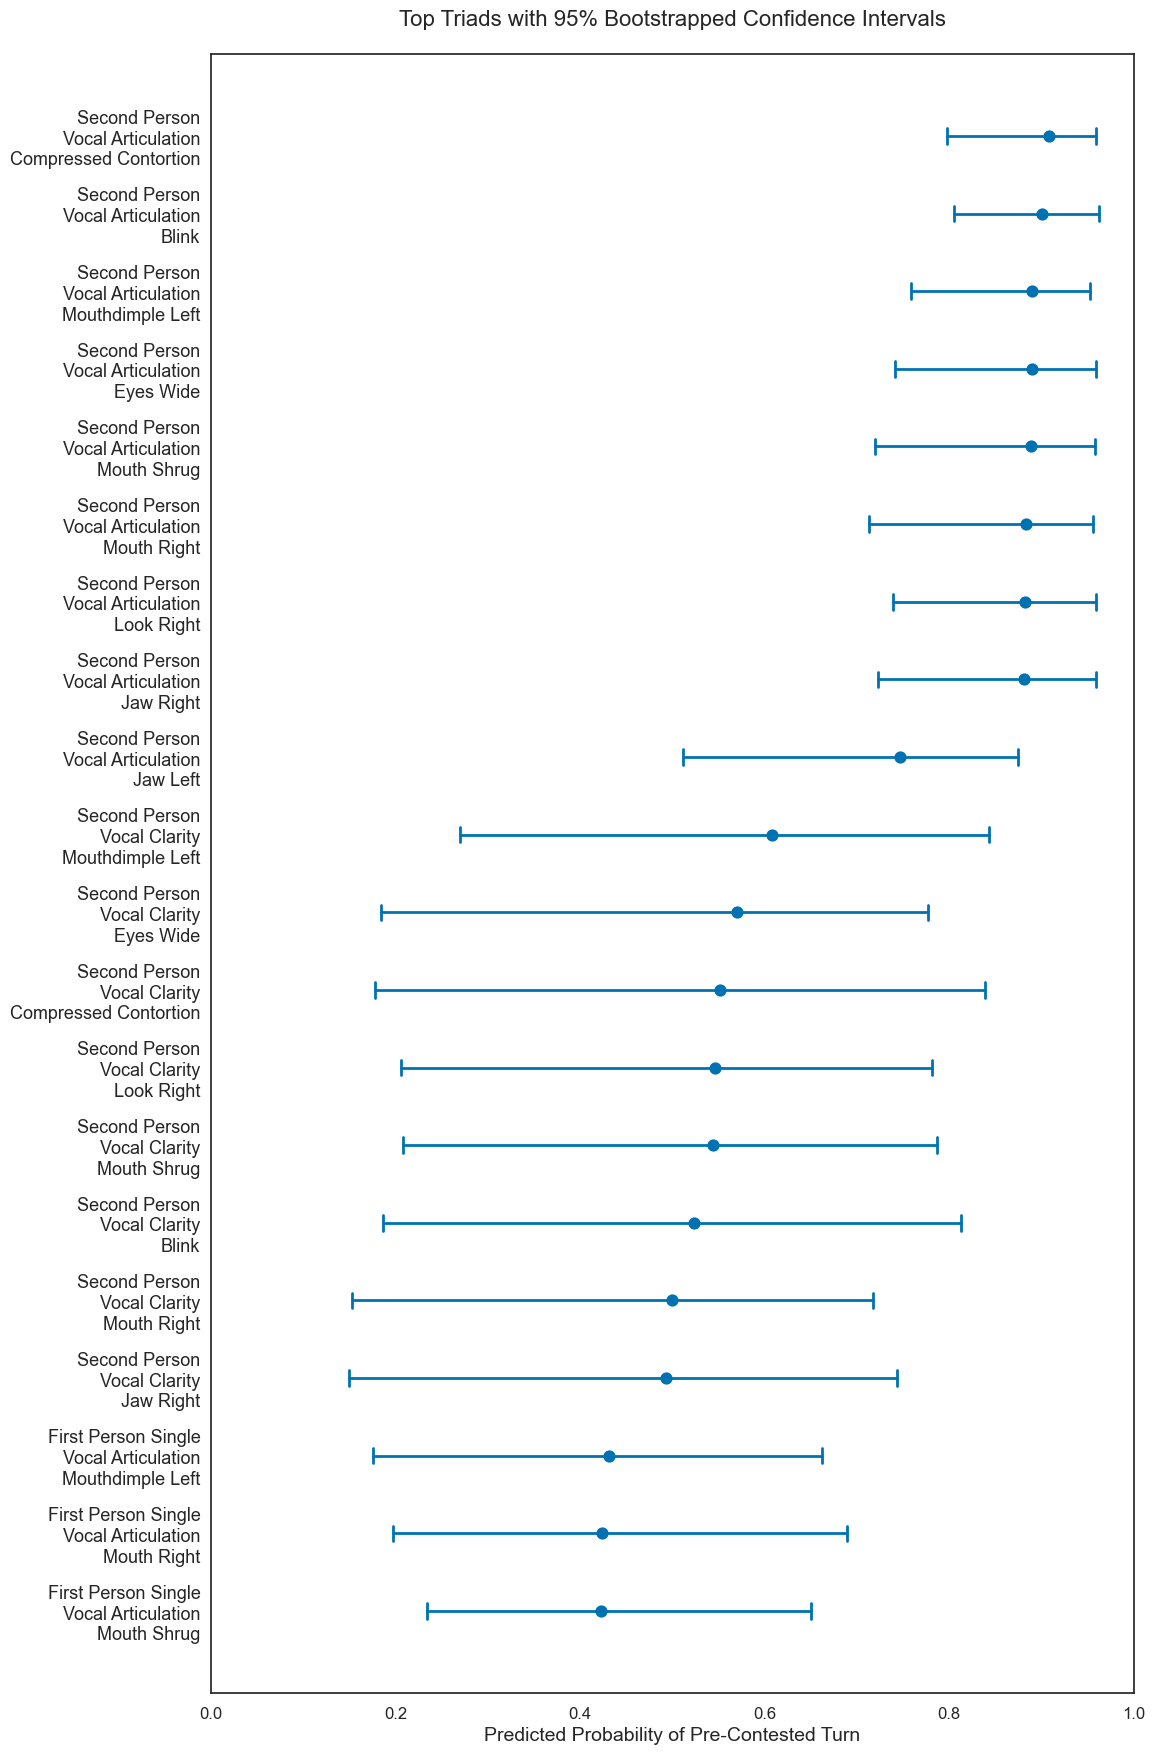

In [46]:
plot_triads_with_ci(triad_results_boot, top_n=20)